<a href="https://colab.research.google.com/github/MINTS12/ML_labs/blob/main/big_data_ai_lab_2_nahla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI & Big Data - Time series - Lab. 2 - Classification

This lab consists of six parts, each building upon the previous one, gradually increasing in complexity.

Deliverables:
- A .ipynb file containing your solutions.
- A PDF export of the notebook, ensuring that all cells have been executed.

For every question, please provide **short** but **informative** answers.

⚠️ Important: While you are free to use external resources, please don't rely blindly on ChatGPT - I'll find out!

Let's go!

## Part 1: Setup environment and download datasets

In [2]:
!pip install aeon
!pip install seaborn
!pip install dtw-python
!pip install tqdm
!pip install fastdtw
!pip install pycatch22

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from aeon.datasets import load_arrow_head, load_basic_motions
from tqdm import tqdm
import pandas as pd
import time
import fastdtw

x_train_full, y_train = load_arrow_head(split='train')
x_test_full, y_test = load_arrow_head(split='test')
print(f"Arrow Head dataset of type {type(x_train_full)} and shapes, x_train: {x_train_full.shape}, y_train: {y_train.shape}, x_test: {x_test_full.shape}, y_test: {y_test.shape}")

Arrow Head dataset of type <class 'numpy.ndarray'> and shapes, x_train: (36, 1, 251), y_train: (36,), x_test: (175, 1, 251), y_test: (175,)


In [5]:
x_train, x_test = x_train_full[:, 0], x_test_full[:, 0]


In [6]:
print(y_train)

['0' '1' '2' '0' '1' '2' '0' '1' '2' '0' '1' '2' '0' '1' '2' '0' '1' '2'
 '0' '1' '2' '0' '1' '2' '0' '1' '2' '0' '1' '2' '0' '1' '2' '0' '1' '2']


**Questions:**
1. What are the dimensions of the downloaded datasets? Write their meaning and value for every subset.
2. What is the format of the labels? How many classes do we have?
3. Look into the documentation of the aeon library and write below the meaning of each class.

**Answers:**

1. The dataset is a 3d  numpy array so since the x_train returned (35, 1, 251) , it means that we have 36 signals of lenght 251 that are univariate.
and we have x_train which is the data we are going to train our modelson and x_test which is the data that we are going to test our model on

2. The lables are a 1D array of  are strings , and for this dataset we have 3 classes {0,1,2}

3. The three classes are called “Avonlea”, “Clovis” and “Mix”.”The classes are based on shape distinctions such as the presence and location of a notch in the arrow.
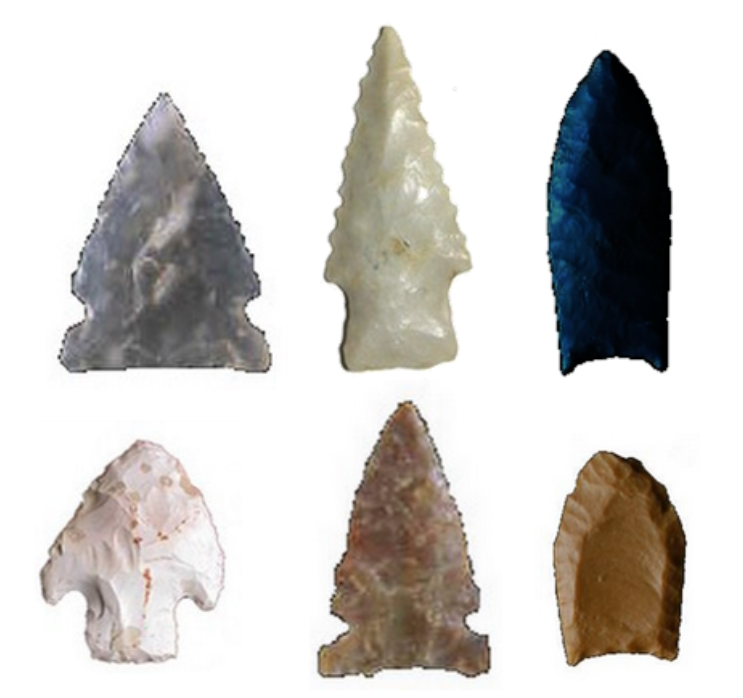


#Part 2: Visualizing and Understanding the Data

- Create a subplot with 3 rows and 2 columns.
- Each row should correspond to a different class in the dataset.
- Each column should distinguish between different subsets (e.g., training vs. test sets, different conditions, etc.).
- Plot all samples within each class to observe variations and patterns.

This visualization will help in understanding the structure of the dataset and how different classes are distributed.

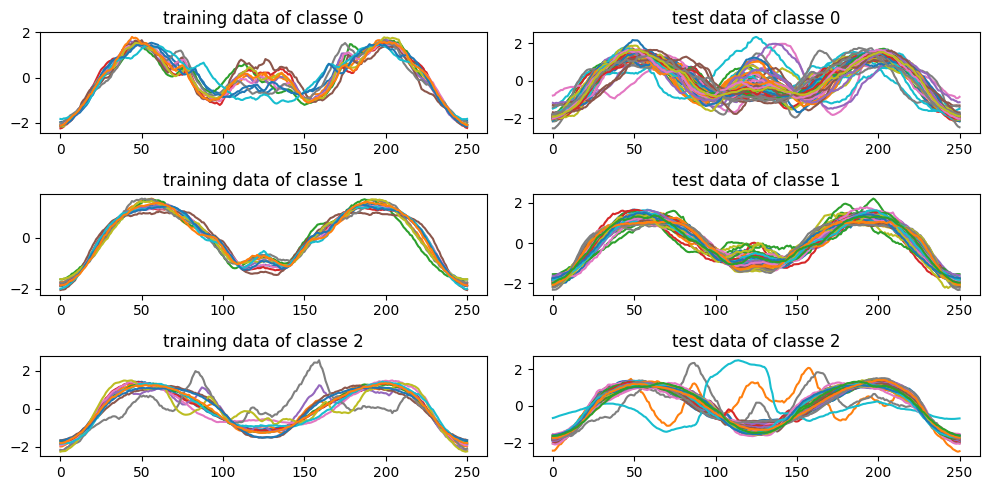

In [7]:
fig, ax = plt.subplots(3, 2, figsize=(10, 5))

# TODO

y_test_in_int = y_test.astype(int)
y_train_in_int = y_train.astype(int)

classes=np.unique(y_train_in_int)


for cls in classes :
  train_signals=x_train[y_train_in_int==cls]
  test_signals=x_test[y_test_in_int==cls]

  for signal in train_signals :
    ax[cls,0].plot(signal)
    ax[cls,0].set_title(f"training data of classe {cls}")
  for signal in test_signals :
    ax[cls,1].plot(signal)
    ax[cls,1].set_title(f"test data of classe {cls}")


plt.tight_layout()
plt.show()

**Questions:**

1. What do you observe? Describe the differences between the classes based on their visual patterns.
2. Do you understand the classification task? If you were the classifier, what key characteristics would you focus on to distinguish between classes?
3. Do you notice any samples that could be problematic? If so, explain why they might be challenging for classification (e.g., overlap between classes, noise, outliers).

**Answers:**


We plotted the training and test dataset for each classe to see the differences between them that can be eventually our features

1. We observe that for :

**Class 0 :** The 2 peaks are more pointy than for the other classes , and has a central boss with a significantly larger range than the other classes.

**Class 1**The 2 largest peaks are a bit more rounded , and there's also a  small but very pointy peak in the center with low amplitude.

**Class 2 :** The signals are generally more smoothed , the slopes of the 2 largest peaks are noticeably smaller  than in other classes .Itdoesn't have a central peak  .


2. The classification task is about to create a model that can assign a specific class based on the features that we choose in our model , so for example specifically here it's about training our model to recognize the geometry of each arrowhead type.

If I was the classifier I would focous on these key characteristics to distinguish between the 3 classes :    


*   The slope of the 2 large peaks  , if they are big so the peaks are pointy etc...
* The peak in the middle , if it's range is large , if it's pointy or more of like just a boss or it doesn't exist at all   


3.
*   There are 3 specific signals in the Class 2 test set that actually show a central peak. Since my classification logic relies on Class 2 not having that peak, these will likely be misclassified as Class 0 or 1.

*   The key identifier for Class 1 is the little  peak. If there is any noise in the signal, that tiny peak could be easily  mistaken for a random fluctuation, leading the model to categorize it as the smoothed Class 2






## Part 3: Distance-based classifiers

### Part 3.1: Implement the Euclidean and the DTW distances

In [8]:
def euclidean_distance(a, b):
  # TODO
  return np.sqrt(np.sum(np.square(a-b)))
  pass

print(f"Euclidian distance value: {euclidean_distance(x_train[0], x_train[1])}")

Euclidian distance value: 5.466689798005681


In [9]:
def dtw(a, b, window=100):
  # TODO
  n, m = len(a), len(b)

  window=min(window, n, m)

  dtw_matrix = np.full((n+1 , m+1) , np.inf )
  dtw_matrix[0,0]= 0

  for i in range(1, n+1):

    lower_limit=max(1, i-window)
    upper_limit=min(m+1, i+window+1)


    for j in range(lower_limit, upper_limit) :
      cost=abs(a[i-1]-b[j-1])
      dtw_matrix[i,j]=cost+min(dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1])

      #this one for L2 dtw
      #dtw_matrix[i,j]=np.square(euclidean_distance(a[i-1], b[j-1]))+min(dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1])

  return dtw_matrix

distance_matrix = dtw(x_train[0], x_train[1], window=1)
print(f"DTW distance value: {np.sqrt(distance_matrix[-1, -1])}")
print(distance_matrix)

DTW distance value: 7.9715037893800185
[[ 0.                 inf         inf ...         inf         inf
          inf]
 [        inf  0.1884376   0.3774106  ...         inf         inf
          inf]
 [        inf  0.3716912   0.3722266  ...         inf         inf
          inf]
 ...
 [        inf         inf         inf ... 63.33690736 63.29046386
          inf]
 [        inf         inf         inf ... 63.53158536 63.43869836
  63.42504426]
 [        inf         inf         inf ...         inf 63.57218086
  63.54487266]]


In [46]:
distance_matrix=dtw(x_train[0], x_train[1], window=100)


In [48]:
distance_matrix0=dtw(x_train[0], x_train[1], window=0)
print(f"DTW distance value: {np.sqrt(distance_matrix0[-1, -1])}")

DTW distance value: 8.529970251653873


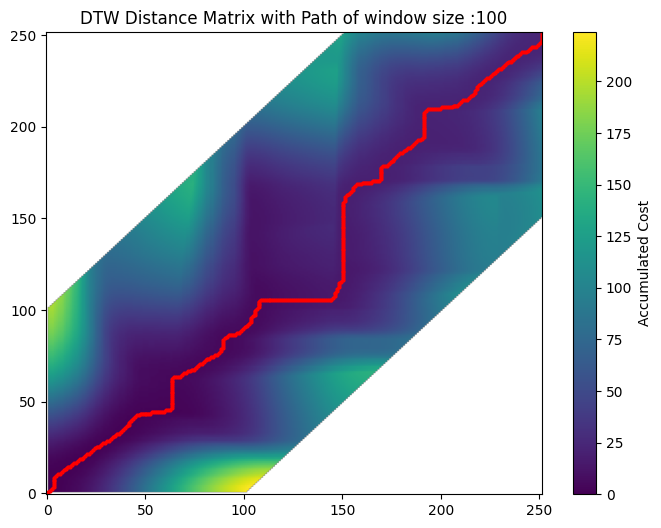

In [34]:
def min_cost_path(matrix):
  i, j = matrix.shape[0] - 1, matrix.shape[1] - 1
  path = [(i, j)]

  while i > 0 or j > 0:
      neighbors = []
      if i > 0:
          neighbors.append((matrix[i-1, j], i-1, j))
      if j > 0:
          neighbors.append((matrix[i, j-1], i, j-1))
      if i > 0 and j > 0:
          neighbors.append((matrix[i-1, j-1], i-1, j-1))

      _, i, j = min(neighbors)
      path.append((i, j))

  return path[::-1]

def visualize_distance_matrix(matrix , window_size):
  path = min_cost_path(matrix)

  fig, ax = plt.subplots(figsize=(8, 6))
  # TODO
  im=ax.imshow(matrix, cmap='viridis', aspect='auto')
  fig.colorbar(im, label='Accumulated Cost')


  path_x, path_y = zip(*path)
  ax.plot(np.array(path_y) + 0.5, np.array(path_x) + 0.5, marker="o", color="red", markersize=2)

  ax.invert_yaxis()
  plt.title(f"DTW Distance Matrix with Path of window size :{window_size}")
  plt.show()

visualize_distance_matrix(distance_matrix ,100)

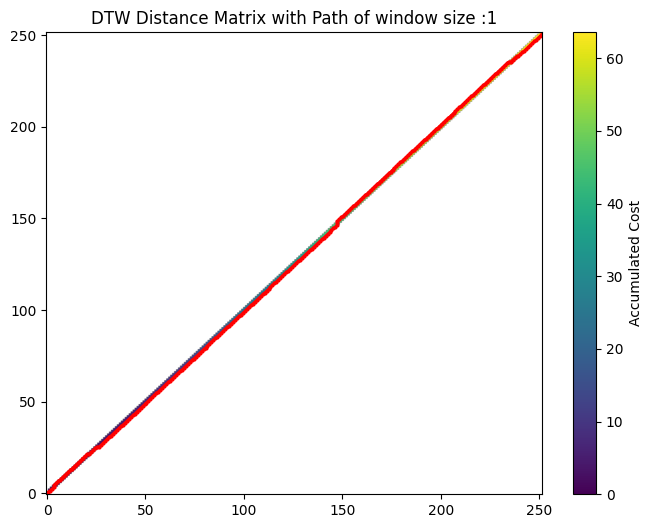

In [35]:
distance_matrix_window1=dtw(x_train[0], x_train[1], window=1)
visualize_distance_matrix(distance_matrix_window1 ,1)

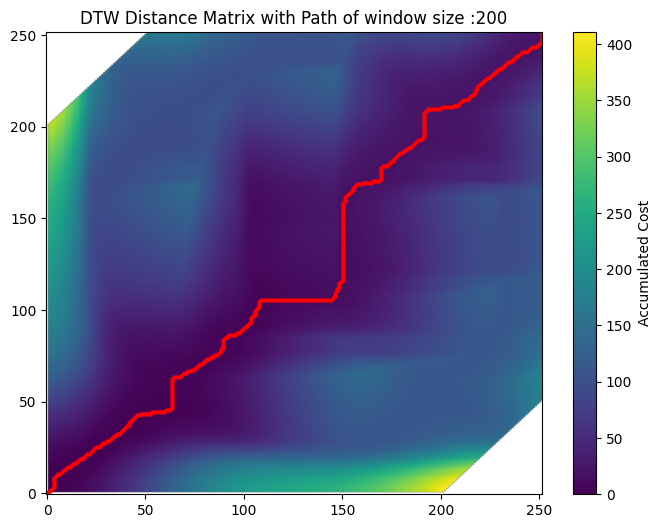

In [36]:
distance_matrix200=dtw(x_train[0], x_train[1], window=200)
visualize_distance_matrix(distance_matrix200 ,200)

In [12]:
def dtw_distance(a, b , window=100):
  # TODOD: Wrapper that returns the final distance
  matrix = dtw(a, b, window)
  return matrix[-1, -1]
  pass
def my_fastdtw(a, b):
    return fastdtw.fastdtw(a, b, radius=20)[0]

print(f"DTW distance value: {dtw_distance(x_train[0], x_train[1])}")
print(f"Fast DTW distance value: {my_fastdtw(x_train[0], x_train[1])}")

DTW distance value: 23.589921960699996
Fast DTW distance value: 23.589921960699996


Run a random example between two time series and answer the questions below.

**Questions:**
1. Does your implementation match the Euclidean distance when window = 1 ? Why or why not?
2. What do you observe as you change the window size? How does it affect the DTW alignment?
3. Up to which value does the window size affect the result? Justify your answer.

**Answers:**



1.   We compared the DTW distance using window = 1 against the standard Euclidean distance to see if they're equal(DTW value:  7.97 and Euclidean value: 5.46)
The DTW result was significantly higher, which was unexpected since DTW usually finds a smallest path, so since window = 1 it still allows a small warping and doesn't take the diagonal , so we were expecting either the euclidian or less.

Reason why it doesn't match even for window = 0 :

The lecture implementation uses the $L_1$ norm (Manhattan distance):$$\sum |x_i - y_j|$$Euclidean distance : Standard Euclidean distance uses the $L_2$ norm:$$\sqrt{\sum (x_i - y_i)^2}$$


2.   We varied the warping window size to see how it restricts the path between the two signals (0, 100 ,200) , so a larger window decreases the distance by searching further away from the same time index



### Part 3.2: Implement the kNN classifier

In [13]:
def knn_classifier_single(x_train, y_train, x_test, distance_function, k=5):
  # TODO
  # Compute the distance of the test value to every train
  distances =[distance_function(x_tr , x_test) for x_tr in x_train ]

  # Find the k min distances
  #distances in ascending order just the k top ones
  nearest_neighbors = np.argsort(distances)[:k]

  # Find the labels of the k nearest neighbors
  k_nearest_labels = y_train[nearest_neighbors]

  # Return their voted most label
  votes = [y_train[i] for i in nearest_neighbors]
  labels = np.unique(k_nearest_labels )
  counts=[votes.count(label) for label in labels ]
  prediction = labels[np.argmax(counts)]

  return prediction

ed_tic = time.time()
knn_classifier_single(x_train, y_train, x_test[0], euclidean_distance, k=5)
ed_toc = time.time()

dtw_tic = time.time()
knn_classifier_single(x_train, y_train, x_test[0], dtw_distance, k=5)
dtw_toc = time.time()

fast_dtw_tic = time.time()
knn_classifier_single(x_train, y_train, x_test[0], my_fastdtw, k=5)
fast_dtw_toc = time.time()

print(f"ED distance time: {(ed_toc - ed_tic):.4f} secs")
print(f"DTW distance time: {(dtw_toc - dtw_tic):.4f} secs")
print(f"Fast DTW distance time: {(fast_dtw_toc - fast_dtw_tic):.4f} secs")

ED distance time: 0.0083 secs
DTW distance time: 2.5081 secs
Fast DTW distance time: 0.0398 secs


In [14]:
def knn_classifier(x_train, y_train, x_test, distance_function, k=5):
  predictions = []
  # TODO: Implement a wrapper for multiple predictions
  for x in x_test :
    predictions.append(knn_classifier_single(x_train, y_train, x, distance_function, k))
  return predictions

preds = knn_classifier(x_train, y_train, x_test, euclidean_distance, k=22)

In [15]:
def accuracy(a, b):
  # TODO
  return np.mean(a==b)
  pass

print(accuracy(preds, y_test))

0.5142857142857142


In [16]:
ed_trials = []
for k in range(1, 20):
  preds_k = knn_classifier(x_train, y_train, x_test, euclidean_distance, k=k)
  acc = accuracy(preds_k, y_test)
  trial = {'k': k, 'accuracy': acc}
  ed_trials.append(trial)
  print(f"Accuracy for k = {trial['k']} is {trial['accuracy']}")

Accuracy for k = 1 is 0.8
Accuracy for k = 2 is 0.8171428571428572
Accuracy for k = 3 is 0.7942857142857143
Accuracy for k = 4 is 0.7028571428571428
Accuracy for k = 5 is 0.6685714285714286
Accuracy for k = 6 is 0.6571428571428571
Accuracy for k = 7 is 0.6457142857142857
Accuracy for k = 8 is 0.6285714285714286
Accuracy for k = 9 is 0.6342857142857142
Accuracy for k = 10 is 0.5828571428571429
Accuracy for k = 11 is 0.6
Accuracy for k = 12 is 0.5828571428571429
Accuracy for k = 13 is 0.5771428571428572
Accuracy for k = 14 is 0.5657142857142857
Accuracy for k = 15 is 0.5542857142857143
Accuracy for k = 16 is 0.5028571428571429
Accuracy for k = 17 is 0.52
Accuracy for k = 18 is 0.5142857142857142
Accuracy for k = 19 is 0.5142857142857142


In [17]:
# preds = knn_classifier(x_train, y_train, x_test, my_fastdtw, 7)
from functools import partial

dtw_trials = []

for w in tqdm(range(1, 20, 2)):
  # TODO: Use best k from above and test for multiple windows
  # TODO: Save results in list of dictionaries
  dtw_distance_window=partial(dtw_distance,window=w)

  preds_window = knn_classifier(x_train, y_train, x_test,dtw_distance_window , k=2)
  acc = accuracy(preds_window, y_test)
  trial = {'window': w, 'accuracy': acc}
  dtw_trials.append(trial)
  print(f"Accuracy for window = {trial['window']} is {trial['accuracy']}")

 10%|█         | 1/10 [00:06<01:02,  6.94s/it]

Accuracy for window = 1 is 0.8


 20%|██        | 2/10 [00:23<01:42, 12.79s/it]

Accuracy for window = 3 is 0.8


 30%|███       | 3/10 [00:48<02:06, 18.10s/it]

Accuracy for window = 5 is 0.8


 40%|████      | 4/10 [01:20<02:22, 23.75s/it]

Accuracy for window = 7 is 0.7828571428571428


 50%|█████     | 5/10 [02:01<02:30, 30.07s/it]

Accuracy for window = 9 is 0.7542857142857143


 60%|██████    | 6/10 [02:50<02:25, 36.47s/it]

Accuracy for window = 11 is 0.7371428571428571


 70%|███████   | 7/10 [03:48<02:10, 43.45s/it]

Accuracy for window = 13 is 0.7314285714285714


 80%|████████  | 8/10 [04:55<01:41, 50.97s/it]

Accuracy for window = 15 is 0.7371428571428571


 90%|█████████ | 9/10 [06:12<00:59, 59.11s/it]

Accuracy for window = 17 is 0.7371428571428571


100%|██████████| 10/10 [07:36<00:00, 45.63s/it]

Accuracy for window = 19 is 0.7485714285714286


In [18]:
ed_trials_df = pd.DataFrame(ed_trials)
dtw_trials_df = pd.DataFrame(dtw_trials)

# TODO: Visualize acc for different k and different window sizes
plt.show()

**Questions:**
1. What is the best value for k and the window size? How do they impact the classification performance?

2. Which distance measure should we use? Justify your choice based on the dataset and DTW behavior.

3. What do you think about the results?

## Part 4: Feature-based classifiers

### Part 4.1: Feature extraction

1. Extract features from the time series data using the Catch22 library. Ensure that each sample is transformed into a feature vector.
2. Convert the extracted features from NumPy arrays to Torch tensors, preparing them for use in a PyTorch model. Don't forget the labels too.

it's important to do it at first randomly

In [19]:
import pycatch22
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler

In [20]:

scaler = StandardScaler()


X_train_features = [pycatch22.catch22_all(x)['values'] for x in x_train]
X_test_features = [pycatch22.catch22_all(x)['values'] for x in x_test]

X_train , Y_train = torch.tensor(X_train_features, dtype=torch.float32),torch.tensor(y_train.astype(int), dtype=torch.long)
X_test , Y_test = torch.tensor(X_test_features, dtype=torch.float32),torch.tensor(y_test.astype(int) , dtype =torch.long)


X_train_np = scaler.fit_transform(X_train.numpy())
X_test_np = scaler.transform(X_test.numpy())

X_train = torch.tensor(X_train_np, dtype=torch.float32)
X_test = torch.tensor(X_test_np, dtype=torch.float32)

### Part 4.2: Setup the training pipeline with Torch

1. Define a simple linear model using PyTorch's nn.Linear. Ensure it takes the extracted feature vectors as input and outputs class probabilities.
2. Choose a loss function and an optimizer, such as Cross-Entropy Loss and Adam/SGD.
3. Implement the training loop, including forward pass, loss computation, backpropagation, and parameter updates. Train the model for a reasonable number of epochs.
4. Evaluate the model on the test set and report relevant metrics (e.g., accuracy, precision, recall).

In [21]:

model = nn.Linear( in_features=22 , out_features=3 )


In [24]:
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [25]:
num_epochs = 1000
batch_size = 16
dataset_size = Y_train.shape[0]

history = []
pbar = tqdm(range(num_epochs), desc='Training', leave=True)

# TODO: Complete the training loop

for n in pbar:
  curr_indexes =torch.randperm(dataset_size)
  epoch_loss= 0
  for i in range(0, dataset_size, batch_size):
    curr_indexes_batch=curr_indexes[i:i+batch_size]
    curr_x =X_train[curr_indexes_batch]
    curr_y =Y_train[curr_indexes_batch]

    outputs=model(curr_x)
    loss=loss_fn(outputs, curr_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_loss+=loss.item()*curr_x.size(0)

  # TODO: Complete the training loop

  with torch.no_grad():
        train_outputs = model(X_train)
        _,predicted = torch.max(train_outputs, 1)
        acc = (predicted == Y_train).sum().item() / dataset_size
        avg_loss = epoch_loss / dataset_size

  history.append({'epoch': n, 'loss': avg_loss, 'accuracy':acc })
  pbar.set_description(f"Training loss {loss}, Training accuracy: {acc}")
  pbar.refresh()

Training loss 0.10171546787023544, Training accuracy: 1.0: 100%|██████████| 1000/1000 [00:07<00:00, 132.37it/s]


In [26]:
# Print the accuracy on the test set

with torch.no_grad():
    test_outputs = model(X_test)
    _, predicted_test = torch.max(test_outputs, 1)
    test_acc = (predicted_test == Y_test).sum().item() / Y_test.size(0)

print(f"MLPs accuracy: {test_acc:.4f}")

MLPs accuracy: 0.5886


In [27]:
# Evaluate the model on the test set
with torch.no_grad():
    test_outputs = model(X_test)
    _, predicted_test = torch.max(test_outputs, 1)
    test_acc = (predicted_test == Y_test).sum().item() / Y_test.size(0)

print(f"MLPs accuracy: {test_acc:.4f}")

MLPs accuracy: 0.5886


In [28]:
df = pd.DataFrame(history)

print(df)

     epoch      loss  accuracy
0        0  1.375440  0.333333
1        1  1.079940  0.583333
2        2  0.901147  0.666667
3        3  0.801108  0.666667
4        4  0.753225  0.666667
..     ...       ...       ...
995    995  0.034024  1.000000
996    996  0.034138  1.000000
997    997  0.034216  1.000000
998    998  0.034289  1.000000
999    999  0.033985  1.000000

[1000 rows x 3 columns]


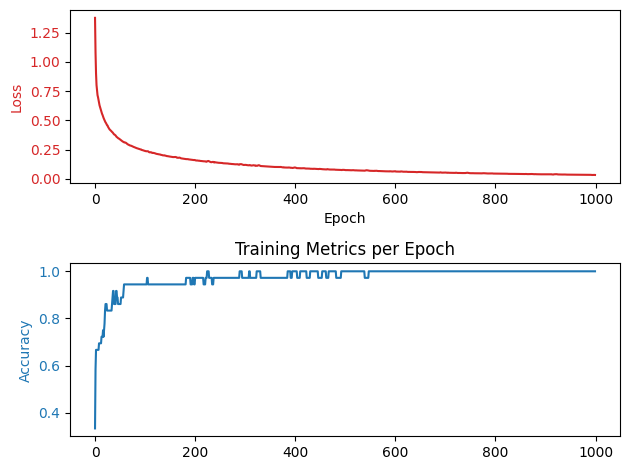

In [29]:
# TODO: Plot the training loss and accuracy per epoch
fig,ax1 = plt.subplots(2,1)

# Plot Loss
ax1[0].set_xlabel('Epoch')
ax1[0].set_ylabel('Loss', color='tab:red')
ax1[0].plot(df['epoch'], df['loss'], color='tab:red', label='Loss')
ax1[0].tick_params(axis='y', labelcolor='tab:red')

# Create a second y-axis for Accuracy
ax1[1].set_ylabel('Accuracy', color='tab:blue')
ax1[1].plot(df['epoch'], df['accuracy'], color='tab:blue', label='Accuracy')
ax1[1].tick_params(axis='y', labelcolor='tab:blue')

plt.title('Training Metrics per Epoch')
fig.tight_layout()
plt.show()


Questions:
1. Experiment with different hyperparameters (n_layers, neurons per layer, activation functions, n_epochs, batch_size, etc.). What is the best combination of hyperparameters you found? Justify your choice.
2. Compare the results of the feature-based approach with the previous approach. Are the results better? Why do you think this is the case, considering the data?

## Part 5: Raw-based classifiers

In this section, we will train a classifier directly on the raw time series data.
1. Prepare the dataset in its raw form (without feature extraction).
2. Define a small 1D Convolutional Neural Network (1D-CNN) architecture for classification.
3. Implement the training pipeline, including:
  * Loss function and optimizer selection
  * Training loop
  * Model evaluation

In [30]:


# ArrowHead raw data: (batch_size, 1, 251)
num_classes = len(torch.unique(Y_train))

model = nn.Sequential(
    nn.Conv1d(in_channels=1, out_channels=16, kernel_size=5),  # -> (batch, 16, 247)
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=2),                               # -> (batch, 16, 123)
    nn.Conv1d(16, 32, kernel_size=5),                          # -> (batch, 32, 119)
    nn.ReLU(),
    nn.MaxPool1d(2),                                           # -> (batch, 32, 59)
    nn.Flatten(),                                              # -> (batch, 32*59)
    nn.Linear(32*59, num_classes)                              # -> (batch, 3)
)

In [ ]:
X_train = torch.tensor(x_train_full, dtype=torch.float32)
X_test = torch.tensor(x_test_full, dtype=torch.float32)

Y_train = torch.tensor(y_train.astype(int), dtype=torch.long)
Y_test = torch.tensor(y_test.astype(int), dtype=torch.long)

print(X_train.shape)  # (36, 1, 251)

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 1000
batch_size = 16
dataset_size = Y_train.shape[0]

cnn_history = []
pbar = tqdm(range(num_epochs), desc='Training', leave=True)

# TODO: Complete the training loop

for n in pbar:
  curr_indexes =torch.randperm(dataset_size)
  epoch_loss= 0
  for i in range(0, dataset_size, batch_size):
    curr_indexes_batch=curr_indexes[i:i+batch_size]
    curr_x =X_train[curr_indexes_batch]
    curr_y =Y_train[curr_indexes_batch]

    outputs=model(curr_x)
    loss=loss_fn(outputs, curr_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_loss+=loss.item()*curr_x.size(0)

  # TODO: Complete the training loop

  with torch.no_grad():
        train_outputs = model(X_train)
        _,predicted = torch.max(train_outputs, 1)
        acc = (predicted == Y_train).sum().item() / dataset_size
        avg_loss = epoch_loss / dataset_size

  cnn_history.append({'epoch': n, 'loss': avg_loss, 'accuracy':acc })
  pbar.set_description(f"Training loss {loss}, Training accuracy: {acc}")
  pbar.refresh()

Training loss 2.6822075938071066e-07, Training accuracy: 1.0: 100%|██████████| 1000/1000 [00:22<00:00, 45.30it/s]


In [ ]:
# Evaluate the model on the test set
# Evaluate the model on the test set
with torch.no_grad():
    test_outputs = model(X_test)
    _, predicted_test = torch.max(test_outputs, 1)
    test_acc = (predicted_test == Y_test).sum().item() / Y_test.size(0)

print(f"CNNs accuracy: {test_acc:.4f}")

CNNs accuracy: 0.8057


In [ ]:
df = pd.DataFrame(cnn_history)

# TODO: Produce the same plots as before
print(df)

     epoch      loss  accuracy
0        0  0.005780  0.972222
1        1  0.005632  0.972222
2        2  0.124045  1.000000
3        3  0.000241  0.944444
4        4  0.158213  0.944444
..     ...       ...       ...
995    995  0.000003  1.000000
996    996  0.000003  1.000000
997    997  0.000003  1.000000
998    998  0.000003  1.000000
999    999  0.000003  1.000000

[1000 rows x 3 columns]


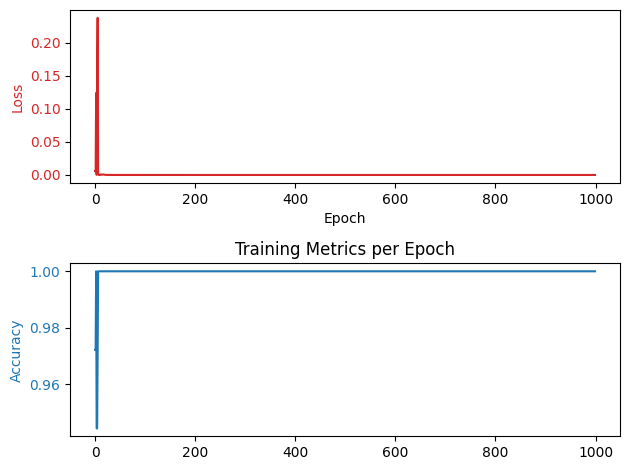

In [ ]:
# TODO: Plot the training loss and accuracy per epoch
fig,ax1 = plt.subplots(2,1)

# Plot Loss
ax1[0].set_xlabel('Epoch')
ax1[0].set_ylabel('Loss', color='tab:red')
ax1[0].plot(df['epoch'], df['loss'], color='tab:red', label='Loss')
ax1[0].tick_params(axis='y', labelcolor='tab:red')

# Create a second y-axis for Accuracy
ax1[1].set_ylabel('Accuracy', color='tab:blue')
ax1[1].plot(df['epoch'], df['accuracy'], color='tab:blue', label='Accuracy')
ax1[1].tick_params(axis='y', labelcolor='tab:blue')

plt.title('Training Metrics per Epoch')
fig.tight_layout()
plt.show()


**Questions:**
1.  Are the results now better than before? If so, why do you think that is?
2. Adjust the hyper-parameters (e.g., number of filters, kernel size, learning rate, batch size, etc.) as you did before. What do you think are the best hyper-parameter settings based on your experiments? Justify your answer by presenting the results and explaining the reasoning behind your choices.

**Answers:**

## Part 6: Discussion

This part of the exercise focuses on discussing your results and demonstrating your understanding of the methods and concepts. Please answer the following questions in at most two short paragraphs.

**Questions:**
- Which method did you like the most, and why?
- Based on your experience, which distance measure do you think works best for this task?
- What did you find challenging to understand, and what concepts did you find straightforward?
- What are the pros and cons of each method you tried?

There are no strictly "correct" answers, but your grade will be based on how well you understand and articulate the concepts. Reflect on what you've done, and make sure to explain your reasoning clearly.

**Answer:**

**The End!**